In [1]:
import numpy as np
from numpy import pi
from qiskit.providers.aer import AerSimulator
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
#from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_textbook.widgets import scalable_circuit

# Constructing a QFT circuit by hand 
Some code here is from qiskit documentation

In [2]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [3]:
scalable_circuit(qft_rotations)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x19\x00\x00\x01\x08\x08\x06\x00\x00\x00\x1a\xcd,…

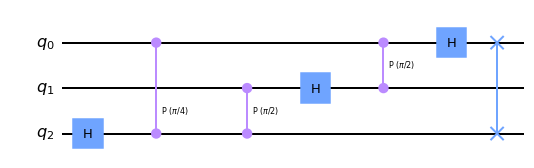

In [4]:
# Let's see how it looks:
qc = QuantumCircuit(3)
qft(qc,3)
qc.draw('mpl')

## Test that our algorithm works properly

First choose an arbitrary binary number that can be represented by the number of qubits we are using.

In [5]:
n = 3 # number of qubits
bin(5)

'0b101'

Our QFT is successful if we can reproduce the binary state, in this case 101, with the highest probability. 

In [6]:
# Create the circuit
qc = QuantumCircuit(n)

# Encode the state 5
qc.x(0)
qc.x(2)

qc.draw('mpl')

We can check that our qubits are in the proper state by vizualizing them on the Bloch sphere.

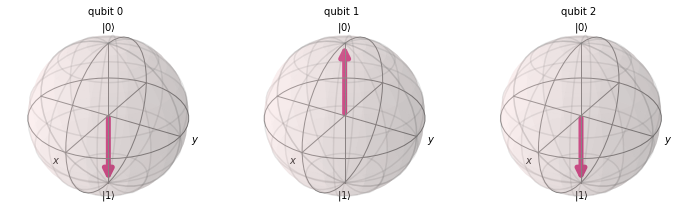

In [7]:
backend = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = backend.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

In [8]:
# add the rest of the circuit
qc = qft(qc,n)
qc.draw('mpl')

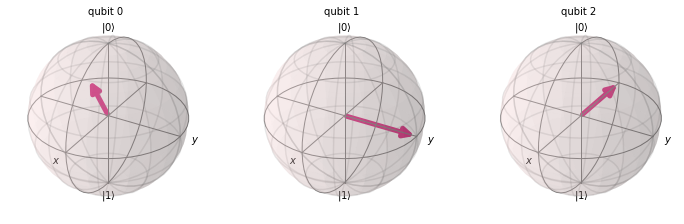

In [9]:
backend = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = backend.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

All of the qubits are in superposition.
To retrieve our original state, we must perform an inverse QFT.

In [10]:
def inv_qft(circuit, n):
    qft_circ = qft(QuantumCircuit(n), n)
    invqft_circ = qft_circ.inverse()
    
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit

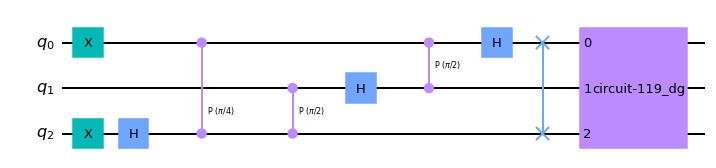

In [11]:
qc = inv_qft(qc,n)
qc.draw('mpl')

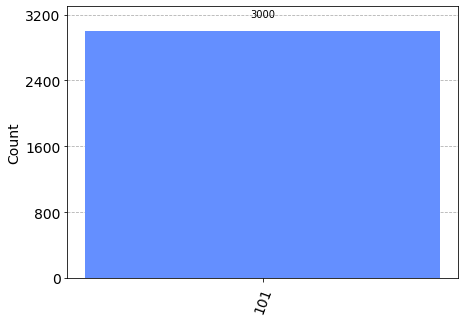

In [12]:
qc.measure_all()
backend = AerSimulator()
compiled_qc = transpile(qc, backend)

sim = backend.run(compiled_qc, shots=3000)
results = sim.result()

counts = results.get_counts(compiled_qc)
plot_histogram(counts)

We see that we have recovered our original state.